In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


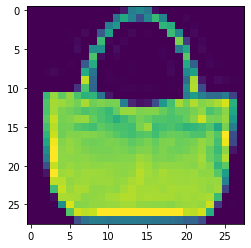

In [4]:
idx = 100
plt.imshow(x_train[idx]);

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [6]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [8]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
938/938 [==============================] - 56s 59ms/step - loss: 0.8048 - accuracy: 0.7035
Epoch 2/3
938/938 [==============================] - 60s 64ms/step - loss: 0.4141 - accuracy: 0.8502
Epoch 3/3
938/938 [==============================] - 55s 59ms/step - loss: 0.3734 - accuracy: 0.8634


In [9]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8873999714851379


In [10]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

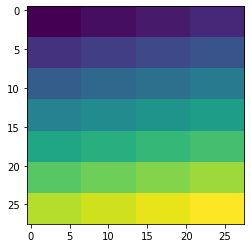

In [11]:
segments = superpixel(x_train[idx])
plt.imshow(segments);

In [12]:
predict_fn = lambda x: cnn.predict(x)

In [13]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

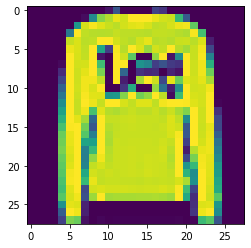

In [14]:
i = 1
image = x_test[i]
plt.imshow(image[:,:,0]);

In [15]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

2

In [16]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

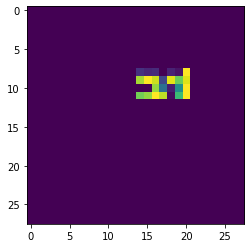

In [17]:
plt.imshow(explanation.anchor[:,:,0]);

In [18]:
#Contrastive Explanations Method (CEM) applied to MNIST

In [19]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


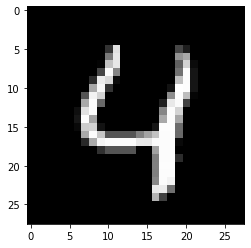

In [20]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4]);

In [21]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [22]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin


In [23]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [24]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1)
cnn.save('mnist_cnn.h5', save_format='h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 32)          0   

In [25]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9854


In [26]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [27]:
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

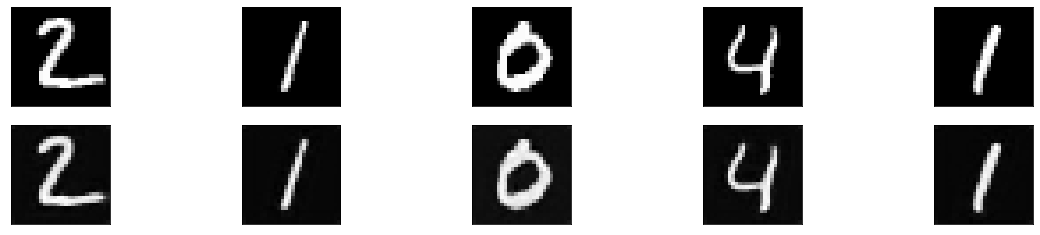

In [28]:
ae = load_model('mnist_ae.h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
# Generate contrastive explanation with pertinent negative

In [30]:
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)

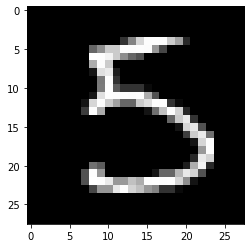

In [31]:
plt.imshow(X.reshape(28, 28));

In [32]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9985821)

In [33]:
#Counterfactual instances on MNIST

In [34]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


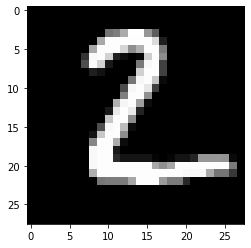

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

In [36]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [37]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin


In [38]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [39]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 32)          0   

In [40]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])


Test accuracy:  0.9894


In [41]:
#Original instance:

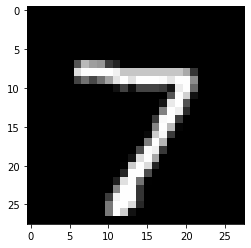

In [42]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

In [43]:
# Counterfactual parameters:

In [44]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

In [45]:
#Run counterfactual:

In [46]:
# initialize explainer
cf = CounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 9.384 sec


In [47]:
#Results:

Counterfactual prediction: 3 with probability 0.9939345717430115


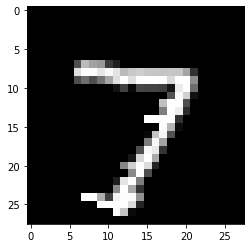

In [48]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

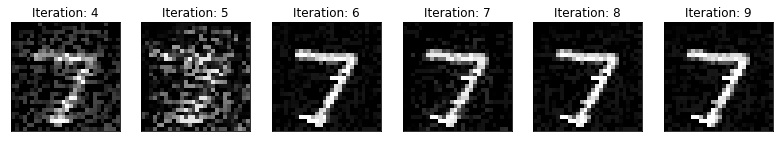

In [49]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [50]:
target_class = 1

cf = CounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 6.205 sec


Counterfactual prediction: 1 with probability 0.9991983771324158


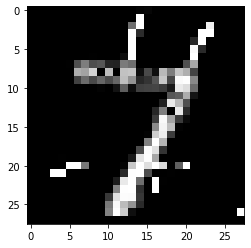

In [51]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));


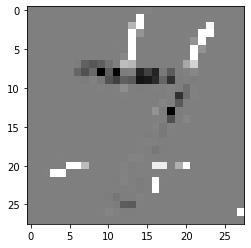

In [52]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));

In [53]:
#Integrated gradients for MNIST

In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True

TF version:  2.4.1
Eager execution enabled:  True


In [3]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [4]:
load_mnist_model = False
save_model = True

In [5]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))


Epoch 1/6
235/235 [==============================] - 75s 316ms/step - loss: 0.8904 - accuracy: 0.7143 - val_loss: 0.1341 - val_accuracy: 0.9587
Epoch 2/6
235/235 [==============================] - 68s 288ms/step - loss: 0.1952 - accuracy: 0.9395 - val_loss: 0.0758 - val_accuracy: 0.9772
Epoch 3/6
235/235 [==============================] - 66s 281ms/step - loss: 0.1358 - accuracy: 0.9573 - val_loss: 0.0580 - val_accuracy: 0.9811
Epoch 4/6
235/235 [==============================] - 72s 305ms/step - loss: 0.1092 - accuracy: 0.9654 - val_loss: 0.0470 - val_accuracy: 0.9844
Epoch 5/6
235/235 [==============================] - 68s 290ms/step - loss: 0.0928 - accuracy: 0.9707 - val_loss: 0.0395 - val_accuracy: 0.9866
Epoch 6/6
235/235 [==============================] - 58s 247ms/step - loss: 0.0799 - accuracy: 0.9759 - val_loss: 0.0376 - val_accuracy: 0.9873


In [7]:
import tensorflow as tf
from alibi.explainers import IntegratedGradients

model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))

ig  = IntegratedGradients(model,
                          layer=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [11]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method)

In [12]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = X_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample,
                         baselines=None,
                         target=predictions)

In [13]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 0}}

In [14]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'baselines', 'predictions', 'deltas', 'target'])

In [15]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]

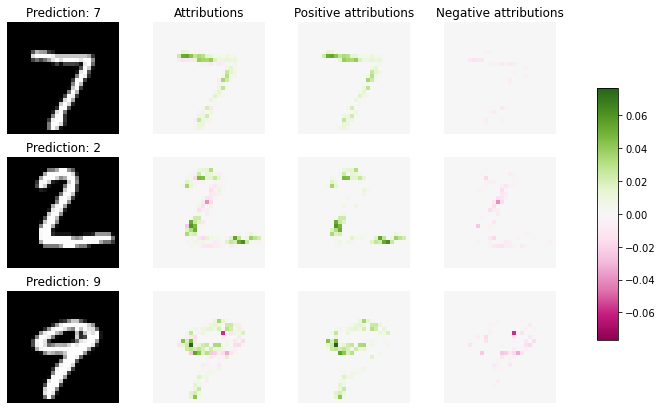

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')

    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));